In [1]:
import configparser
from models.UNet3D_v1 import UNet3d
from solver import PolyLR
from dataset.data import *
from models.loss import *
from models.utils import summarize_model
import os
import torch
import nibabel as nib
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [2]:
#!pip install torchviz
from torchviz import make_dot
from torchsummary import summary

In [3]:
#!pip install graphviz

In [4]:
def get_hparams():
    config = configparser.ConfigParser()
    config.read("config.ini")
    params = config['params']
    modes = params['modes'].split(",")
    shapes = params['input_shape'].split(",")
    hyper_parameters = {
        "test_set" : params['test_dataset'],
        "train_set" : params['train_dataset'],
        "init_channels" : int(params['init_channels']),
        "in_channels" : len(modes),
        "input_shape" : (int(shapes[0]), int(shapes[1]), int(shapes[2])),
        "batch_size" : int(params['batch_size'])
    }
    
    return hyper_parameters

hparams = get_hparams()

## Load Model

In [5]:
def get_model(model_name, hyper_parameters):
    if model_name == "3dunet":
        model = UNet3d(in_channels=hyper_parameters["in_channels"], n_classes=3, n_channels=hyper_parameters['init_channels'])
    else:
        raise Exception("Not Implemented")
    return model

In [6]:
unet3d = get_model("3dunet", hparams)

In [7]:
unet3d = unet3d.to(device)
summary(unet3d, input_size=(4, 160, 192, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 160, 192, 128]           1,744
         GroupNorm-2    [-1, 16, 160, 192, 128]              32
              ReLU-3    [-1, 16, 160, 192, 128]               0
            Conv3d-4    [-1, 16, 160, 192, 128]           6,928
         GroupNorm-5    [-1, 16, 160, 192, 128]              32
              ReLU-6    [-1, 16, 160, 192, 128]               0
        DoubleConv-7    [-1, 16, 160, 192, 128]               0
         MaxPool3d-8       [-1, 16, 80, 96, 64]               0
            Conv3d-9       [-1, 32, 80, 96, 64]          13,856
        GroupNorm-10       [-1, 32, 80, 96, 64]              64
             ReLU-11       [-1, 32, 80, 96, 64]               0
           Conv3d-12       [-1, 32, 80, 96, 64]          27,680
        GroupNorm-13       [-1, 32, 80, 96, 64]              64
             ReLU-14       [-1, 32, 80,

In [8]:
def load_model_from_ckpt(model, model_path):
    model_state_dict = torch.load(model_path)
    model.load_state_dict(model_state_dict)
    return model

In [9]:
model_path = "trained_models/3D-UNet/experiment_2/best_model.pth"
model = load_model_from_ckpt(unet3d, model_path)

## Load/Visualize Predictions on Validation Dataset

In [10]:
# Get Predictions

In [11]:
def get_loader():
    loaders = make_data_loaders(mode="train", model_name="3dunet")
    val_loader = loaders['val']
    return val_loader

In [12]:
loader = get_loader()

In [13]:
def get_preds(model, loader):
    predictions = []
    model = model.to(device)
    for i, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(inputs)
        predictions.append(output)
    return predictions

In [14]:
predictions = get_preds(model, loader)

In [15]:
# Visualize Predictions

In [72]:
def visualize_2D(idx, preds, patient_list):
    sample_idx = idx
    slice_idx = preds[0].shape[2] // 2
    # get input images and ground truth mask
    folder_name = patient_list[sample_idx].split('/')[-1]
    t1 = nib.load(patient_list[sample_idx] + "/" + folder_name + "_t1.nii.gz").get_data()[:,:,slice_idx]
    t1 = skTrans.resize(t1, (160,192), order=1, preserve_range=True)
    t1ce = nib.load(patient_list[sample_idx] + "/" + folder_name + "_t1ce.nii.gz").get_data()[:,:,slice_idx]
    t1ce = skTrans.resize(t1ce, (160,192), order=1, preserve_range=True)
    t2 = nib.load(patient_list[sample_idx] + "/" + folder_name + "_t2.nii.gz").get_data()[:,:,slice_idx]
    t2 = skTrans.resize(t2, (160,192), order=1, preserve_range=True)
    flair = nib.load(patient_list[sample_idx] + "/" + folder_name + "_flair.nii.gz").get_data()[:,:,slice_idx]
    flair = skTrans.resize(flair, (160,192), order=1, preserve_range=True)
    seg = nib.load(patient_list[sample_idx] + "/" + folder_name + "_seg.nii.gz").get_data()[:,:,slice_idx]
    seg = skTrans.resize(seg, (160,192), order=1, preserve_range=True)
    
    # get prediction
    predicted_mask = preds[sample_idx].cpu().squeeze().numpy()
    pred_WT = predicted_mask[0][:,:,slice_idx]
    pred_TC = predicted_mask[1][:,:,slice_idx]
    pred_ET = predicted_mask[2][:,:,slice_idx]
    
    
    fig = plt.figure(figsize=(20, 10))

    # Input Image
    plt.subplot(151)
    plt.imshow(t1)
    plt.title('T1')
    
    # Input Image
    plt.subplot(152)
    plt.imshow(t1ce)
    plt.title('T1CE')
    
    # Input Image
    plt.subplot(153)
    plt.imshow(t2)
    plt.title('T1')
    
    # Input Image
    plt.subplot(154)
    plt.imshow(flair)
    plt.title('FLAIR')
    plt.show()
    
    
    fig = plt.figure(figsize=(20, 10))
    # Ground Truth Mask
    plt.subplot(151)
    plt.imshow(seg)
    plt.title('Ground Truth Mask')

    
    # WT Predicted Mask
    plt.subplot(152)
    plt.imshow(pred_WT)
    plt.title('WT Predicted Mask')

    # TC Predicted Mask
    plt.subplot(153)
    plt.imshow(pred_TC)
    plt.title('TC Predicted Mask')

    # ET Predicted Mask
    plt.subplot(154)
    plt.imshow(pred_ET)
    plt.title('ET Predicted Mask')
    plt.show()
    

In [73]:
patient_val_df = pd.read_csv("dataset/val_data.csv")
patient_val_list = patient_val_df['val'].values.tolist()

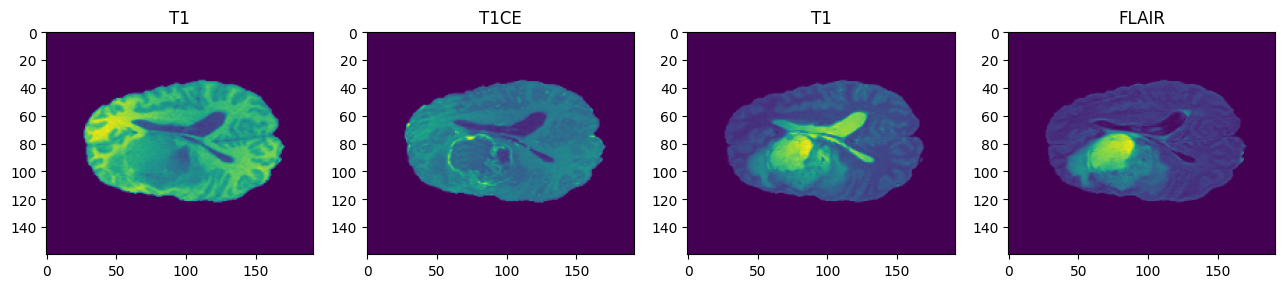

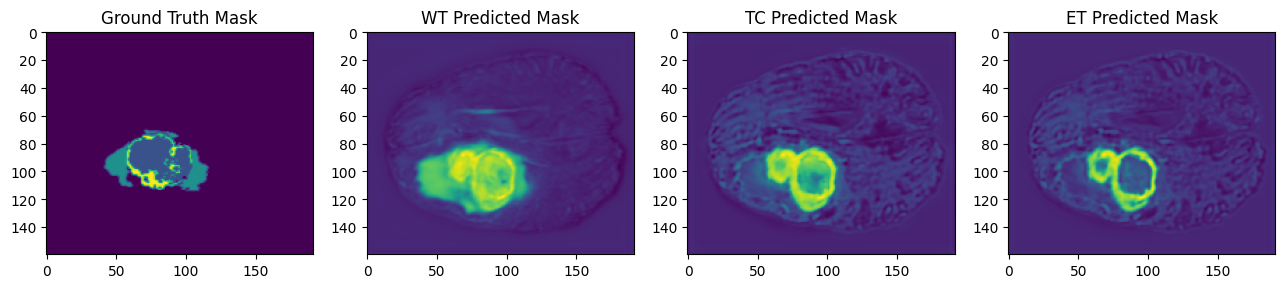

In [74]:
idx = 1
visualize_2D(idx, predictions, patient_val_list)
# experiment_2

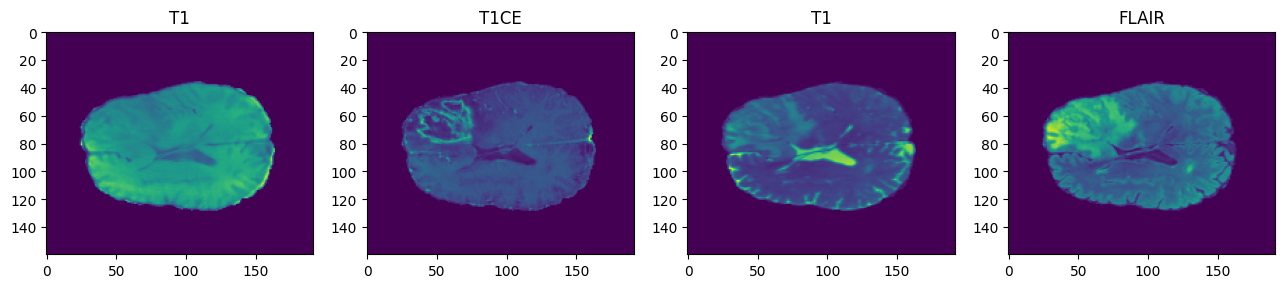

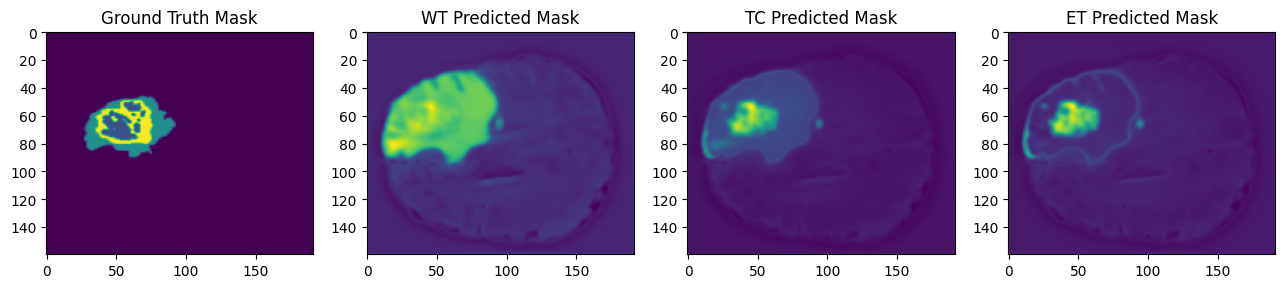

In [112]:
idx = 0
visualize_2D(idx, predictions, patient_val_list)
# experiment_1